In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numexpr as ne
import time
import copy
import sys

from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../pytorch_utils/')
from utils import get_data, top_k_accuracy, per_class_accuracy

In [3]:
import torch.cuda
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.benchmark = True

# Load data

In [5]:
%%time
X_train, X_val, Y_train, Y_val = get_data()
train_size = len(X_train)
val_size = len(X_val)
print(train_size, val_size)

51200 5120
CPU times: user 1min 32s, sys: 10.8 s, total: 1min 43s
Wall time: 41.5 s


# Create iterators

In [6]:
val_data = TensorDataset(
    torch.FloatTensor(X_val), 
    torch.LongTensor(Y_val)
)

val_iterator = DataLoader(
    val_data, batch_size=64, shuffle=False, pin_memory=True
)

In [7]:
train_data = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(Y_train)
)

train_iterator = DataLoader(
    train_data, batch_size=64, shuffle=False, pin_memory=True
)

# Get models

In [8]:
sys.path.append('../densenet/')
sys.path.append('../resnet/')
sys.path.append('../inception_v3/')

from model_densenet import make_model as make_densenet
from model_resnet import make_model as make_resnet
from model_inception import make_model as make_inception

In [9]:
densenet, _, _ = make_densenet()
densenet = densenet.cpu()

resnet, _, _ = make_resnet()
resnet = resnet.cpu()

inception, _, _ = make_inception()
inception = inception.cpu()

In [10]:
all_models = [
    (densenet, '../densenet/model_state0.pytorch'),
    (resnet, '../resnet/model_state0.pytorch'),
    (inception, '../inception_v3/model_state0.pytorch')
]

# Try ensemble

In [11]:
ensemble_predictions = {}

In [12]:
%%time
for i, (model, state) in enumerate(all_models):
    
    model.load_state_dict(torch.load(state))
    model = model.cuda()
    ensemble_predictions[i] = []
    model.eval()
    
    for x_batch, _ in tqdm(val_iterator):

        x_batch = Variable(x_batch.cuda(), volatile=True)
        logits = model(x_batch)

        # compute probabilities
        probs = F.softmax(logits) 
        ensemble_predictions[i] += [probs.cpu().data.numpy()]
    
    model = model.cpu()

100%|██████████| 80/80 [00:27<00:00,  3.04it/s]

CPU times: user 1min 5s, sys: 14.6 s, total: 1min 19s
Wall time: 1min 24s


In [13]:
ensemble_predictions = {
    p: np.concatenate(ensemble_predictions[p], axis=0) 
    for p in ensemble_predictions
}

In [14]:
predictions = np.stack(ensemble_predictions.values()).mean(0)

In [15]:
accuracy_score(Y_val, predictions.argmax(1))

0.86093750000000002

In [16]:
log_loss(Y_val, predictions)

0.83280372345684273

In [17]:
top_k_accuracy(Y_val, predictions, 2)

0.91874999999999996

In [18]:
top_k_accuracy(Y_val, predictions, 3)

0.9404296875

In [19]:
top_k_accuracy(Y_val, predictions, 5)

0.96015625000000004

In [20]:
per_class_acc = per_class_accuracy(Y_val, predictions)
per_class_acc

array([ 0.9 ,  0.85,  0.75,  0.7 ,  0.85,  0.85,  0.85,  0.95,  0.95,
        0.8 ,  1.  ,  1.  ,  0.8 ,  1.  ,  0.95,  0.7 ,  0.8 ,  0.7 ,
        0.95,  0.95,  0.85,  1.  ,  1.  ,  0.9 ,  0.75,  0.6 ,  1.  ,
        0.95,  0.95,  0.7 ,  0.8 ,  0.85,  0.65,  0.95,  0.9 ,  0.95,
        0.9 ,  0.85,  0.6 ,  1.  ,  0.95,  0.75,  0.8 ,  0.75,  0.85,
        0.95,  1.  ,  0.85,  0.95,  0.8 ,  0.85,  0.85,  0.95,  0.85,
        0.9 ,  0.75,  1.  ,  0.8 ,  0.5 ,  0.75,  0.9 ,  1.  ,  1.  ,
        0.9 ,  0.95,  0.95,  0.85,  0.95,  0.8 ,  0.8 ,  0.9 ,  1.  ,
        0.85,  0.55,  0.65,  0.95,  0.95,  0.75,  0.75,  0.55,  0.95,
        0.8 ,  0.8 ,  1.  ,  0.75,  0.95,  0.85,  0.8 ,  0.9 ,  1.  ,
        1.  ,  0.9 ,  0.95,  0.95,  0.85,  0.85,  0.7 ,  0.95,  0.85,
        0.95,  0.95,  0.95,  0.85,  0.9 ,  0.8 ,  0.9 ,  0.95,  0.75,
        1.  ,  1.  ,  0.9 ,  0.95,  0.95,  1.  ,  0.75,  0.9 ,  0.85,
        1.  ,  0.95,  0.8 ,  1.  ,  0.7 ,  1.  ,  0.95,  0.75,  0.65,
        1.  ,  0.85,

# Error analysis

In [21]:
erroneous = Y_val != predictions.argmax(1)
n_errors = len(Y_val[erroneous])
n_errors

712

In [22]:
to_show = np.random.choice(np.arange(0, n_errors), size=30, replace=False)

In [23]:
pictures = X_val[erroneous][to_show].copy()
pictures_predictions = predictions.argmax(1)[erroneous][to_show]
pictures_probs = predictions.max(1)[erroneous][to_show]
pictures_true = Y_val[erroneous][to_show]

In [24]:
mean = np.array([0.485, 0.456, 0.406], dtype='float32')
std = np.array([0.229, 0.224, 0.225], dtype='float32')
decode = np.load('../utils/decode.npy')[()]

In [25]:
pictures = np.transpose(pictures, axes=(0, 2, 3, 1))
ne.evaluate('pictures*std', out=pictures);
ne.evaluate('pictures + mean', out=pictures);

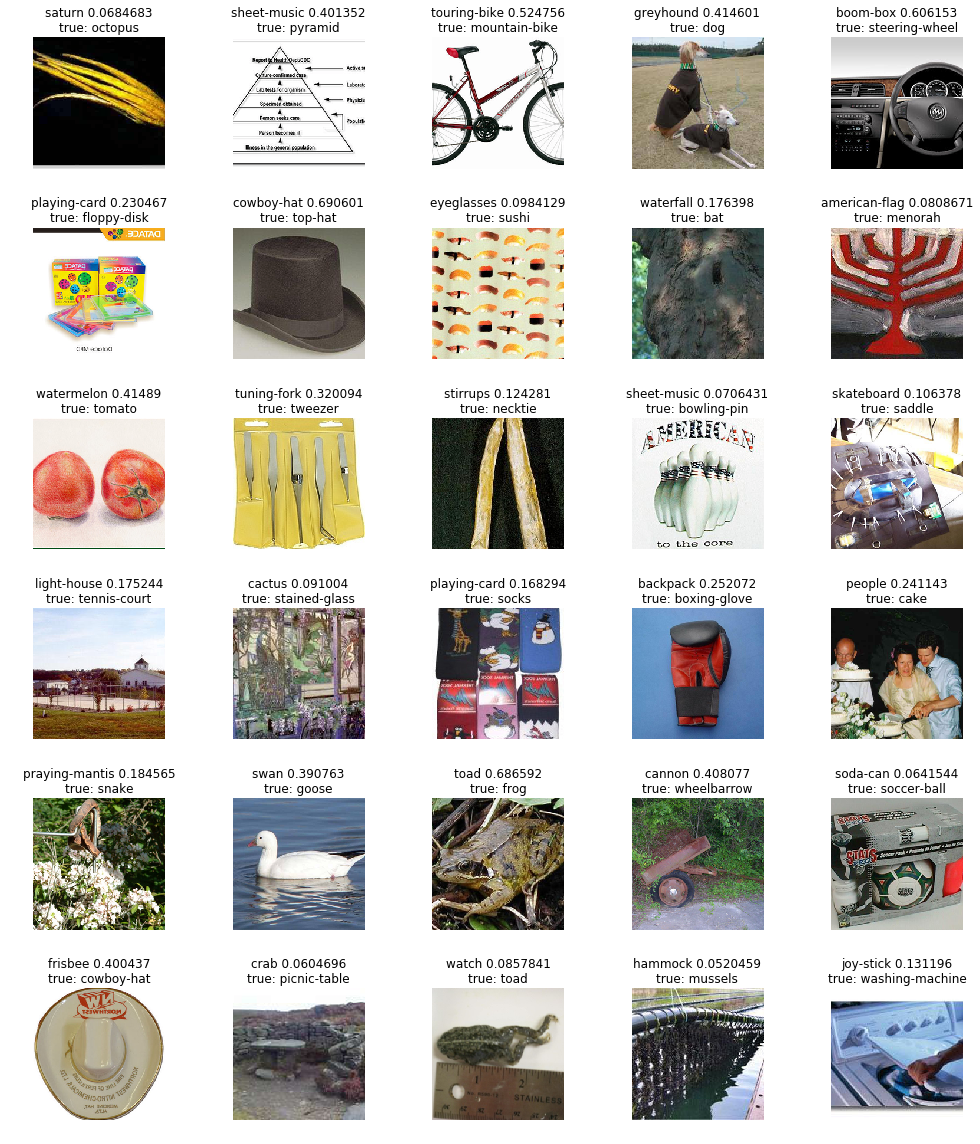

In [26]:
# show pictures, predicted classes and probabilities
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(14, 16))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
    title = decode[pictures_predictions[i] + 1] + ' ' +\
        str(pictures_probs[i]) + '\ntrue: ' + decode[pictures_true[i] + 1]
    axes[i].set_title(title);
plt.tight_layout()

# Get logits

In [27]:
train_logits = {}

In [28]:
%%time
for i, (model, state) in enumerate(all_models):
    
    model.load_state_dict(torch.load(state))
    model = model.cuda()
    train_logits[i] = []
    model.eval()
    
    for x_batch, _ in tqdm(train_iterator):

        x_batch = Variable(x_batch.cuda(), volatile=True)
        logits = model(x_batch)
        train_logits[i] += [logits.cpu().data.numpy()]
        
    model = model.cpu()

100%|██████████| 800/800 [04:22<00:00,  3.03it/s]

CPU times: user 10min 54s, sys: 2min 15s, total: 13min 9s
Wall time: 13min 7s


In [29]:
train_logits = {
    p: np.concatenate(train_logits[p], axis=0) 
    for p in train_logits
}

In [30]:
np.save('/home/ubuntu/data/train_logits.npy', train_logits)